<a href="https://colab.research.google.com/github/TobiasSunderdiek/cartoon-gan/blob/master/CartoonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CartoonGAN

This notebook contains the implementation of the cartoon GAN model. It is implemented with PyTorch.

## Generate dataset

### cartoons images

- Download cartoon images from kaggle to local computer as desribed in README of this project [here](https://github.com/TobiasSunderdiek/cartoon-gan/blob/master/README.md)
- upload generated file `safebooru.zip` to this colab notebook files directory by executing cell below

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving safebooru.zip to safebooru.zip
User uploaded file "safebooru.zip" with length 2780683 bytes


- extract images and place in folder `cartoons` by executing cell below

In [0]:
!mkdir cartoons
!mkdir cartoons/1
!unzip safebooru.zip -d cartoons/1/ #extract to subfolder due to DataLoader needs subdirectories

Archive:  safebooru.zip
  inflating: cartoons/1/1c2c251746db4d4f364bb4cdd38849fc4e10969a.jpg  
  inflating: cartoons/1/1bd51ce723e4ea7c99c660d12019df3684cce3c8.jpg  
  inflating: cartoons/1/1f99464d5091db37943d70e3badfad3f469dd50d.jpg  
  inflating: cartoons/1/1dc37f0391625f46abdb7f7327ede667aa71ee2f.jpg  
  inflating: cartoons/1/1c4d706a888fcac9199dc2fcc6bec2d55c19a7ea.jpg  
  inflating: cartoons/1/1e200c59a35bd636f1a6e9ccef76adbfd82182ca.jpg  
  inflating: cartoons/1/1b17f4fa4c4a1800f10ff52dea71192128d0f9f6.jpg  
  inflating: cartoons/1/2a07cead7f05578dc72599b13a8e835edc00fdbc.jpg  
  inflating: cartoons/1/1c0d86a4cc7892bb4b1ec314e482b097673f7053.jpg  


##### data-loader

As mentioned in the paper, the used image size is 256x256 pixel.

In [0]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

image_size = 256
batch_size = 25

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

cartoon_image_dataloader = DataLoader(ImageFolder('cartoons/', transformer), batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


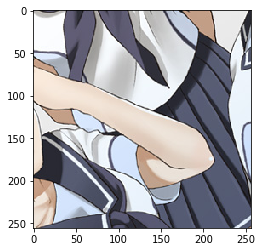

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_image(dataloader):
  iterator = iter(dataloader)
  sample_batch, _ = iterator.next()
  first_sample_image_of_batch = sample_batch[0]
  print(first_sample_image_of_batch.size())
  print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
  plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

show_sample_image(cartoon_image_dataloader)

### photos

- Download photos from coco to local computer as desribed in README of this project [here](https://github.com/TobiasSunderdiek/cartoon-gan/blob/master/README.md)
- upload generated file `coco.zip` to this colab notebook files directory by executing cell below

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving coco.zip to coco.zip
User uploaded file "coco.zip" with length 1996341 bytes


In [0]:
!mkdir photos
!mkdir photos/1
!unzip coco.zip -d photos/1 #extract to subfolder due to DataLoader needs subdirectories

Archive:  coco.zip
  inflating: photos/1/000000002006.jpg  
  inflating: photos/1/000000001490.jpg  
  inflating: photos/1/000000003255.jpg  
  inflating: photos/1/000000001584.jpg  
  inflating: photos/1/000000002299.jpg  
  inflating: photos/1/000000002261.jpg  
  inflating: photos/1/000000002473.jpg  
  inflating: photos/1/000000003156.jpg  
  inflating: photos/1/000000002685.jpg  
  inflating: photos/1/000000001761.jpg  
  inflating: photos/1/000000002532.jpg  
  inflating: photos/1/000000002153.jpg  
  inflating: photos/1/000000002431.jpg  


##### data-loader
same configuration as cartoon data loader above

In [0]:
photo_dataloader = DataLoader(ImageFolder('photos/', transformer), batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


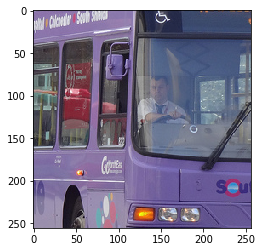

In [0]:
show_sample_image(photo_dataloader)

### more pre-processing
In the GAN a *tanh* activation function for the generator works best. As *tanh* scales the output between -1 and 1. To make this output comparable to the input which has a range between 0 -1 (see current range at sample output),  pre-processing the images is needed.

In [0]:
transformer_with_normalization = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cartoon_image_dataloader = DataLoader(ImageFolder('cartoons/', transformer_with_normalization), batch_size, shuffle=True, num_workers=0)
photo_dataloader = DataLoader(ImageFolder('photos/', transformer_with_normalization), batch_size, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
Current range: -0.9137254953384399 to 1.0


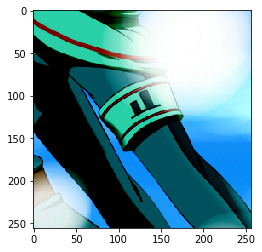

In [0]:
show_sample_image(cartoon_image_dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
Current range: -1.0 to 1.0


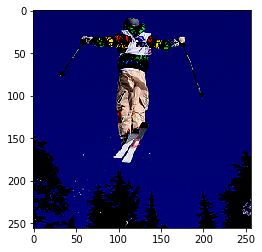

In [0]:
show_sample_image(photo_dataloader)

##Define model

###Generator

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1)
      self.norm_1 = nn.BatchNorm2d(64)
      
      self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
      self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1)
      self.norm_2 = nn.BatchNorm2d(128)
      
      self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2)
      self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1)
      self.norm_3 = nn.BatchNorm2d(256)

    def forward(self, x):
      x = F.leaky_relu(self.norm_1(self.conv_1(x)))
      x = F.leaky_relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = F.leaky_relu(self.norm_3(self.conv_5(self.conv_4(x))))

      return x

In [18]:
Generator()

Generator(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)